# $\text{Arrow Debreu European Option Pricing}$

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import nnls

In [2]:
ticker = 'AAPL'
ticker_data = yf.Ticker(ticker)
expiry = ticker_data.options[4]
print('Using Expiry:', expiry)
chain = ticker_data.option_chain(expiry)
calls = chain.calls #the pricing will be based just on calls 

Using Expiry: 2025-09-12


In [3]:
spot = ticker_data.history(period='1d')['Close'].iloc[-1]
possible_states = np.linspace(spot - 50, spot + 50, 11, dtype=int)
print('Using Spot:', spot)
print(f'Will be pricing options for the following spot prices: {possible_states} expiring on {expiry}')

Using Spot: 229.35000610351562
Will be pricing options for the following spot prices: [179 189 199 209 219 229 239 249 259 269 279] expiring on 2025-09-12


In [4]:
available_strikes = sorted(calls["strike"])
print('Available Strikes:\n', available_strikes)

Available Strikes:
 [140.0, 150.0, 175.0, 180.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 280.0, 325.0]


In [5]:
atm_index = min(range(len(available_strikes)), key=lambda i: abs(available_strikes[i] - spot))
print('Index of the closest strike price to the spot price:', atm_index)

Index of the closest strike price to the spot price: 12


In [6]:
lower_bound = max(atm_index - 5, 0)
upper_bound = min(atm_index + 6, len(available_strikes))
print(f'Lower index bound: {lower_bound}\n', f'Upper undex bound: {upper_bound}')

Lower index bound: 7
 Upper undex bound: 18


In [7]:
chosen_strikes = available_strikes[lower_bound:upper_bound]
chosen_strikes = np.array(chosen_strikes)
print(f'Selected {len(chosen_strikes)} strikes around ATM:', '\n', sorted(chosen_strikes))

Selected 11 strikes around ATM: 
 [205.0, 210.0, 215.0, 220.0, 225.0, 230.0, 235.0, 240.0, 245.0, 250.0, 255.0]


In [8]:
chosen_calls = calls[calls['strike'].isin(chosen_strikes)].copy().reset_index(drop=True)
chosen_calls = chosen_calls[['strike', 'bid', 'ask']]
chosen_calls.head()

,strike,bid,ask
0,205.0,26.00,26.40
1,210.0,21.40,22.15
2,215.0,17.20,17.50
3,220.0,13.35,13.60
4,225.0,9.95,10.10


In [9]:
chosen_calls['price_vector'] = (chosen_calls['bid']+chosen_calls['ask'])/2
chosen_calls = chosen_calls[['strike', 'price_vector']]
chosen_calls.head()

,strike,price_vector
0,205.0,26.200
1,210.0,21.775
2,215.0,17.350
3,220.0,13.475
4,225.0,10.025


In [10]:
strikes = chosen_calls["strike"].values
price_vector = chosen_calls["price_vector"].values
print(strikes)
print(price_vector)

[205. 210. 215. 220. 225. 230. 235. 240. 245. 250. 255.]
[26.2   21.775 17.35  13.475 10.025  7.125  4.825  3.125  1.955  1.21
  0.745]


In [11]:
terminal_prices = strikes.copy()
call_payoff_matrix = np.maximum(possible_states - chosen_strikes[:, None], 0)
put_payoff_matrix  = np.maximum(chosen_strikes[:, None] - possible_states, 0)
print(f'Call payoff matrix piece:\n {call_payoff_matrix[:5,:5]}\n Put payoff matrix piece\n {put_payoff_matrix[:5,:5]}\n Payoff matrices shape: {call_payoff_matrix.shape}')


Call payoff matrix piece:
 [[ 0.  0.  0.  4. 14.]
 [ 0.  0.  0.  0.  9.]
 [ 0.  0.  0.  0.  4.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
 Put payoff matrix piece
 [[26. 16.  6.  0.  0.]
 [31. 21. 11.  1.  0.]
 [36. 26. 16.  6.  0.]
 [41. 31. 21. 11.  1.]
 [46. 36. 26. 16.  6.]]
 Payoff matrices shape: (11, 11)


In [12]:
#state_prices, _, _, _ = np.linalg.lstsq(call_payoff_matrix, price_vector, rcond=None)
state_prices, _ = nnls(call_payoff_matrix, price_vector)
normalized_state_prices = state_prices/np.sum(state_prices)

r=0.0416
T=30/365
probabilities = state_prices * np.e**(r*T)

In [13]:
#'p.s. "np.linalg.lstsq" was resulting in some values being negative so I had to use "scipy.optimize.nnls" i.e non-negative least squares.')

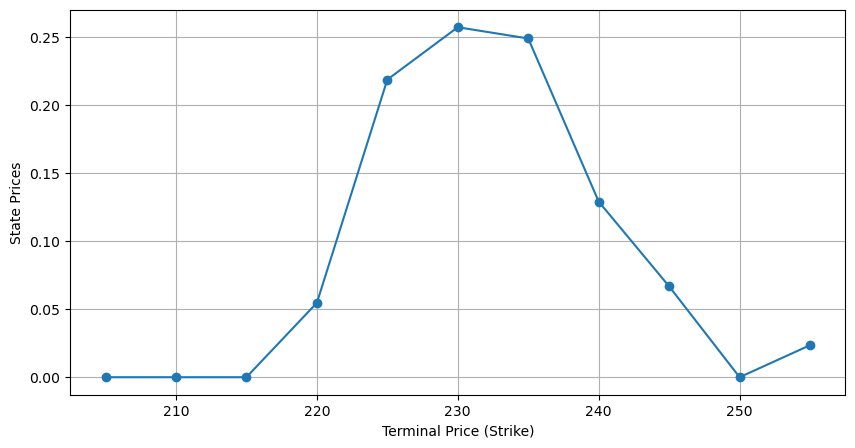

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(terminal_prices, normalized_state_prices, marker='o')
plt.xlabel('Terminal Price (Strike)')
plt.ylabel('State Prices')
plt.grid(True)
plt.show()

In [15]:
call_prices = call_payoff_matrix @ normalized_state_prices
put_prices = put_payoff_matrix @ normalized_state_prices

call_prices = pd.DataFrame({
    'Strike': chosen_strikes,
    '$Call': call_prices,
    '$Put': put_prices
})
call_prices


,Strike,$Call,$Put
0,205.0,28.975668,0.000000
1,210.0,24.030382,0.054714
2,215.0,19.303950,0.328282
3,220.0,14.796476,0.820808
4,225.0,11.164835,2.189167
5,230.0,7.790700,3.815032
6,235.0,5.446583,6.470915
7,240.0,3.351682,9.376014
8,245.0,2.253644,13.277976
9,250.0,1.284815,17.309147


In [16]:
print(state_prices)

[0.         0.         0.         0.04947241 0.19798362 0.23283756
 0.22534266 0.11683164 0.06043467 0.         0.02130437]
